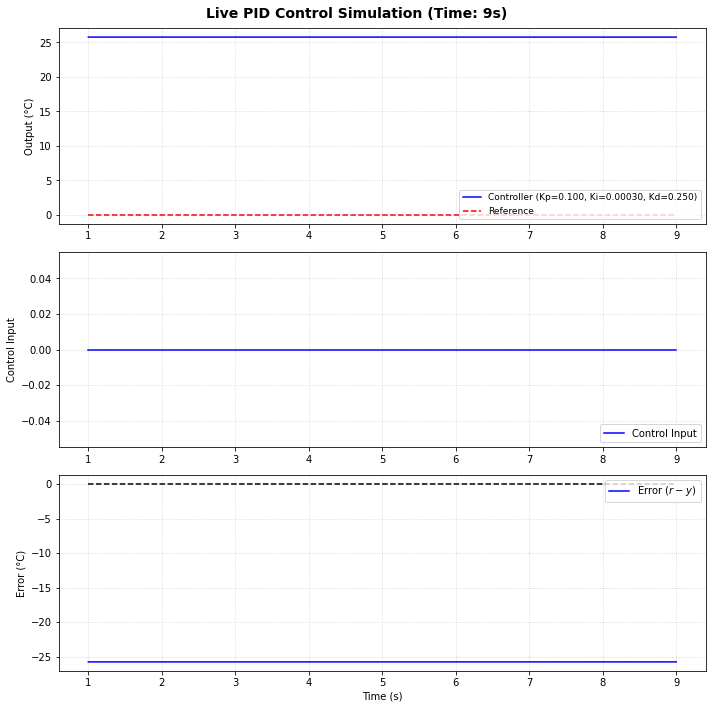

In [1]:
# Live Step-by-Step PID Sandbox with Interactive Control

from IPython.display import display, Javascript, clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import ipywidgets as widgets
import os
import time

# --- 1. System State Class and PID Controller Setup ---

class PIDSystem:
    """Manages the state and simulation logic for a single PID controller and ARX model."""
    def __init__(self, A, B, k, r, u_thresh, y0, sim_time, sigma):
        # System Parameters
        self.A = A
        self.B = B
        self.k = k
        self.u_thresh = u_thresh
        self.r = r
        self.N = sim_time
        self.sigma = sigma
        self.rng = np.random.default_rng(seed=100)
        self.na, self.nb = len(A), len(B)
        self.L = max(self.na, self.nb)

        # Ensure A and B are same length for dot product
        if self.na > self.nb: self.B = np.concatenate([self.B, np.zeros(self.na - self.nb)])
        elif self.nb > self.na: self.A = np.concatenate([self.A, np.zeros(self.nb - self.na)])
        
        # State Arrays (Max size for plotting)
        self.t_history = []
        self.u_history = []
        self.y_history = []
        self.r_history = []
        self.e_history = []

        # Current Step Variables (PID memory)
        self.time_step = 0
        self.y = [y0] * self.L # Initialize with y0 for initial ARX lookback
        self.ut = [0.0] * self.L # Initialize with 0 for initial ARX lookback
        self.err_prev = 0.0
        self.integral_err = 0.0
        self.Kp, self.Ki, self.Kd = 0.0, 0.0, 0.0
        self.is_controller_enabled = False # Toggle state
        
        # PID control parameters for filtering (TCLab standard)
        self.alpha = 0.5
        self.dt = 1.0


    def set_gains(self, Kp, Ki, Kd):
        """Update controller gains."""
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd

    def set_enabled(self, enabled):
        """Set the controller active state."""
        self.is_controller_enabled = enabled
        
    def step(self):
        """Performs one time step of the ARX simulation and PID control."""
        if self.time_step >= self.N:
            print("Simulation complete.")
            return

        i = self.time_step + self.L # Index in the padded arrays
        current_r = self.r[self.time_step]

        # 1. ARX Model Prediction (Output Calculation)
        # y[i] = -A[1:] * y[i-1:i-na:-1] + B * ut[i-k:i-nb-k:-1] + e[i]
        
        # Add noise (using small sigma for stability)
        noise = self.rng.normal(0, self.sigma)
        
        # Calculate next output y[i]
        next_y = (-np.dot(self.A[1:], self.y[-self.na + 1 :][::-1]) + 
                  np.dot(self.B, self.ut[-self.nb - self.k:][::-1]) + 
                  noise)
        
        self.y.append(next_y)
        current_y = next_y
        
        # 2. Error Calculation
        current_err = current_r - current_y
        
        # 3. Control Input Calculation (ut[i+1])
        if self.is_controller_enabled:
            # Update Integral
            self.integral_err += current_err * self.dt
            
            # Calculate Derivative
            d_err = current_err - self.err_prev
            # Filtered derivative term
            d_term = self.Kd * (self.alpha * d_err / self.dt + (1 - self.alpha) * d_err)
            
            # Control Law
            next_ut = (self.Kp * current_err + 
                       self.Ki * self.integral_err + 
                       d_term)
            
            # Apply Saturation
            next_ut = np.clip(next_ut, 0, self.u_thresh)

            self.err_prev = current_err # Update for next derivative step
        else:
            # If disabled, control input is zero
            next_ut = 0.0
            
            # Importantly, integral should be zeroed or held if control is off
            # Here we just stop accumulating if Ki=0, but if we want bumpless transfer, we should hold/reset
            if self.Ki == 0.0:
                 self.integral_err = 0.0
        
        self.ut.append(next_ut)
        
        # 4. History Logging (using the newly calculated state)
        self.time_step += 1
        self.t_history.append(self.time_step)
        self.y_history.append(current_y)
        self.u_history.append(self.ut[-self.L]) # Input applied at time t
        self.r_history.append(current_r)
        self.e_history.append(current_err)


def setup_live_simulation():
    """Sets up data, system, controller, and GUI for the live simulation."""
    
    # --- 1. DATA LOADING AND SYSTEM PARAMETERS ---
    data_filename = 'prbs_test_18_Jun_2025_13_50_02.mat'

    if not os.path.exists(data_filename):
        print("Downloading data file...")
        os.system('wget -O prbs_test_18_Jun_2025_13_50_02.mat https://raw.githubusercontent.com/AlasMac/TCLab-Python-Resources/main/prbs_test_18_Jun_2025_13_50_02.mat')
        if not os.path.exists(data_filename):
            print("Error: Could not download or find the required .mat data file.")
            return None

    try:
        data = loadmat(data_filename)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    T = data['T']
    u_data_test = data['U'][0, :] # Used only for length determination
    y0 = T[0, 0]

    # Model parameters
    A = [1, -3.88098254, 5.64726905, -3.6515443, 0.88525793]
    B = [0.4453368, -1.71110786, 2.49838163, -1.64272524, 0.41012833]
    k = 0
    sigma = 1e-5

    # Setpoint
    SIM_TIME = len(u_data_test)
    r = np.zeros(SIM_TIME + 1, dtype=float) # Add 1 extra step for array access safety
    r[100:] = 30 # Step change in setpoint
    u_thresh = 0.75 # Control Input Saturation Limit

    # Initialize the system state
    global system
    system = PIDSystem(A, B, k, r, u_thresh, y0, SIM_TIME, sigma)
    
    # --- 2. PLOTTING FUNCTION ---

    def plot_live():
        """Updates the live plot based on the current system history."""
        # Use ion() for interactive plotting
        plt.ion()
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        fig.suptitle(f'Live PID Control Simulation (Time: {system.time_step}s)', fontsize=14, fontweight='bold')
        
        # Current Gains for display
        Kp, Ki, Kd = system.Kp, system.Ki, system.Kd
        
        if not system.t_history:
            # Handle initial empty state
            for ax in axes:
                ax.set_xlim(0, system.N)
                ax.grid(True, linestyle=':', alpha=0.6)
            axes[0].set_ylim(0, 40)
            axes[1].set_ylim(-0.1, system.u_thresh + 0.1)
            axes[2].set_ylim(-40, 40)
            axes[0].set_ylabel('Output (°C)')
            axes[1].set_ylabel('Control Input')
            axes[2].set_ylabel('Error (°C)')
            axes[2].set_xlabel('Time (s)')
            plt.tight_layout()
            plt.show()
            return
            
        t_hist = np.array(system.t_history)
        y_hist = np.array(system.y_history)
        u_hist = np.array(system.u_history)
        r_hist = np.array(system.r_history)
        e_hist = np.array(system.e_history)
        
        label_gains = f'Controller (Kp={Kp:.3f}, Ki={Ki:.5f}, Kd={Kd:.3f})'
        
        # --- Subplot 1: Output ---
        axes[0].plot(t_hist, y_hist, 'b', label=label_gains)
        axes[0].plot(t_hist, r_hist, '--r', label='Reference')
        axes[0].set_ylabel('Output (°C)')
        axes[0].legend(loc='lower right', fontsize=9)
        axes[0].grid(True, linestyle=':', alpha=0.6)

        # --- Subplot 2: Control Input ---
        axes[1].plot(t_hist, u_hist, 'b', label='Control Input')
        axes[1].set_ylabel('Control Input')
        axes[1].legend(loc='lower right')
        axes[1].grid(True, linestyle=':', alpha=0.6)
        
        # --- Subplot 3: Error Signal ---
        axes[2].plot(t_hist, e_hist, 'b', label='Error ($r-y$)')
        axes[2].plot(t_hist, np.zeros_like(t_hist), 'k--') # Zero line for error
        axes[2].set_ylabel('Error (°C)')
        axes[2].set_xlabel('Time (s)')
        axes[2].legend(loc='upper right')
        axes[2].grid(True, linestyle=':', alpha=0.6)
        
        # Calculate Steady State Error (SSE) if past the step change
        if system.time_step > 150:
            window = 50
            sse = np.mean(np.abs(e_hist[-window:]))
            axes[2].text(0.05, 0.90, 
                         f'Approx. SSE: {sse:.4f} °C (Last {window}s)', 
                         transform=axes[2].transAxes, 
                         color='blue', 
                         fontsize=10, 
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.tight_layout()
        plt.show()
        plt.ioff()


    # --- 3. INTERACTIVE LOGIC AND GUI SETUP ---
    
    # Initial Gains
    Kp_default, Ki_default, Kd_default = 0.1, 0.0003, 0.25
    system.set_gains(Kp_default, Ki_default, Kd_default)

    # Widgets
    style = {'description_width': 'initial', 'handle_color': 'lightblue'}
    Kp_widget = widgets.FloatText(value=Kp_default, description='Kp:', style=style)
    Ki_widget = widgets.FloatText(value=Ki_default, description='Ki:', style=style)
    Kd_widget = widgets.FloatText(value=Kd_default, description='Kd:', style=style)
    
    # Button to advance time one step (The "live" control)
    step_button = widgets.Button(description="⏩ Step (1s)",
                                 button_style='info',
                                 layout=widgets.Layout(width='150px', height='40px'))
    
    # Toggle button to enable/disable the controller (The "spacebar" control)
    input_toggle = widgets.ToggleButton(value=False,
                                        description='Enable Controller',
                                        button_style='danger',
                                        tooltip='Toggle PID control ON/OFF',
                                        layout=widgets.Layout(width='150px'))
    
    # Button to reset the simulation
    reset_button = widgets.Button(description="🔄 Reset Sim",
                                  button_style='warning',
                                  layout=widgets.Layout(width='150px', height='40px'))

    # Update Function
    def update_simulation(b):
        """Runs one step, updates gains, and redraws the plot."""
        clear_output(wait=True)

        # 1. Update system with current widget values
        system.set_gains(Kp_widget.value, Ki_widget.value, Kd_widget.value)
        system.set_enabled(input_toggle.value)
        
        # 2. Execute one time step
        system.step()
        
        # 3. Re-display GUI and plot
        display(input_box)
        plot_live()

    # Reset Function
    def reset_simulation(b):
        """Resets the system state to initial conditions."""
        global system
        # Reinitialize the system (resets all history and state)
        system = PIDSystem(A, B, k, r, u_thresh, y0, SIM_TIME, sigma)
        system.set_gains(Kp_widget.value, Ki_widget.value, Kd_widget.value)
        
        # Reset GUI elements visually (optional, but good practice)
        input_toggle.value = False
        
        # Rerun update to show initial state
        update_simulation(None)


    # Link actions
    step_button.on_click(update_simulation)
    reset_button.on_click(reset_simulation)
    # The toggle state is picked up by update_simulation when the step button is pressed

    # Layout
    gain_box = widgets.VBox([Kp_widget, Ki_widget, Kd_widget], layout=widgets.Layout(width='200px'))
    control_box = widgets.VBox([step_button, input_toggle, reset_button], 
                               layout=widgets.Layout(align_items='center'))
    
    input_box = widgets.HBox([
        widgets.VBox([widgets.Label("⚙️ PID Gains:"), gain_box]),
        widgets.Label(" "),
        widgets.VBox([widgets.Label("🕹️ Simulation Control:"), control_box])
    ], layout=widgets.Layout(justify_content='space-around', border='2px solid #ccc', padding='10px', margin='10px 0'))


    # Initial run to display the plot and GUI
    clear_output(wait=True)
    display(input_box)
    plot_live()
    
    # Hide code
    display(Javascript("""
      var cells = Jupyter.notebook.get_cells();
      var current_cell_index = cells.indexOf(Jupyter.notebook.get_selected_cell());
      var target_cell = cells[current_cell_index];

      if (target_cell) {
        target_cell.collapse_input();
      }
    """))

# Run the setup function
setup_live_simulation()